# Digitale Zaubertinte: Steganography workshop

**Author:** Verena Lachner, Martin Beneš

## What is steganography?

The art and science of **hiding a secret message** in an inconspicuous cover object

Today, our cover object is a digital image

## Notebook setup

For this notebook, we will use a sample image `nockspitze.png`. Run following code chunk to download it.

In [1]:
# download nockspitze from GitHub
import requests
res = requests.get(f'https://github.com/uibk-uncover/mip-stego-demo/raw/main/img/nockspitze.png')
with open('nockspitze.png', 'wb') as f:
    f.write(res.content)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.stats
import seaborn as sns
import string
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(threshold=99)
plt.rcParams["figure.figsize"] = (12, 3)
np.random.seed(12345)

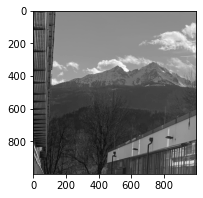

In [3]:
cover = np.array(Image.open('nockspitze.png')) # load image
plt.imshow(cover,cmap = "gray");

## LSB Replacement Steganography

Idea: A human cannot distinguish between neighboring color values.

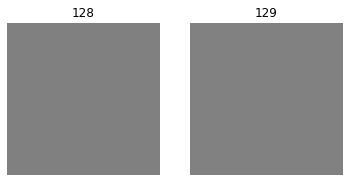

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
for i, v in enumerate([0, 1]):
    ax[i].imshow([[128+v]], vmin=0, vmax=255, cmap='gray');
    ax[i].set_title(f'{128+v}'); ax[i].axis('off');

Not even when they are joined together, really

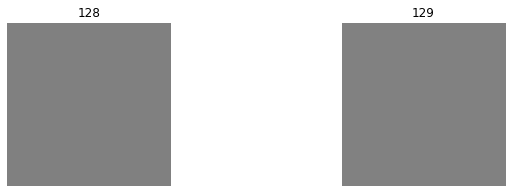

In [5]:
fig, ax = plt.subplots(1, 2)
for i, v in enumerate([0, 1]):
    ax[i].imshow([[128+v]], vmin=0, vmax=255, cmap='gray');
    ax[i].set_title(f'{128+v}'); ax[i].axis('off');
    fig.subplots_adjust(wspace=0);

We will use that to hide our secret message

### A computer sees everything as bits (0s and 1s)

| What we see      |     What a computer sees        |
|:----------------:|:-------------------------------:|
| "hi"             |     $01101000$ $01101001$       |
| $129$            |           $10000001$            |
| $128$            |           $10000000$            |

Color values of a pixel are composed of 8 bits

Idea: Replace least significant bit (LSB) by message bit

<span style="font-family: courier">secret message: 011010...</span>

<center>
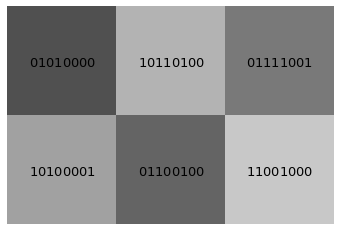
</center>

### Idea: Replace least significant bit (LSB) by message bit

<span style="font-family: courier; font-weight: normal">secret message: <span style="color: blue">0</span><span style="color: red">1</span><span style="color: green">1</span><span style="color: purple">0</span><span style="color: pink">1</span><span style="color: orange">0</span>...</span>

<center>
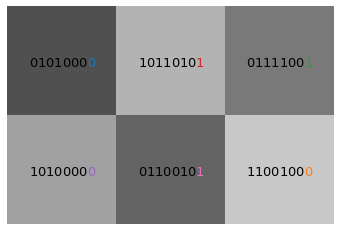
</center>

## How do we implement it?

### First, the message

Pass the super secret message you want to embed.

In [6]:
message = 'super secret secret!'

But we are too lazy today to write a long message. We will generate a random one.

In [7]:
letters_digits = list(string.ascii_letters+string.digits)

In [8]:
N = int(cover.size * .5) // 8  # message length

In [9]:
N

62500

In [10]:
message = ''.join(np.random.choice(letters_digits, size=N))

In [11]:
message[:30] + '...'

'ILDbKPLIDb2X7oPB32qYjlnkrsMhRN...'

Translate the message to 0s and 1s.

We add a stop code "000000000" at the end of the message to let receiver know, when the message ended.

In [12]:
message_bits = []
for character in message.encode('ascii') + b'\x00':
    for i in range(8):  # character has 8 bits
        message_bits.append((character >> i) & 1)  # collect bit
message_bits = np.array(message_bits)

In [13]:
len(message_bits)

500008

We embed the message sequentially starting from the first pixel.

In [14]:
perm = np.linspace(0, cover.size-1, cover.size, dtype='int')

For each pixel, we replace its LSB by the respective message bit

In [15]:
# iterate elements
stego = cover.copy()
for i, it in enumerate(perm):
    if len(message_bits) <= i:
        break  # end of message

    # get index (x- and y-coordinate of pixel)
    idx = it // cover.shape[1], it % cover.shape[1]

    # change
    stego[idx] &= ~0 << 1
    stego[idx] |= message_bits[i]

We successfully embedded. 
As proof I will show you the difference between cover and stego image

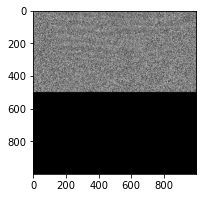

In [16]:
plt.imshow(cover != stego, vmin=0, vmax=1, cmap='gray');

## But we have a problem

Because we embedded sequentially into a very homogeneous region (the sky), 
our modifications are obvious if we look only into the LSB plane

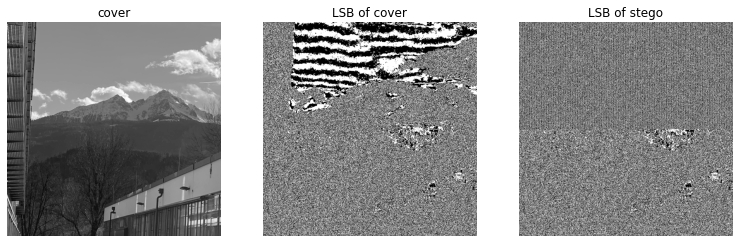

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(13, 13))
ax[0].imshow(cover, cmap = "gray");
ax[1].imshow(cover & 1, cmap = "gray");
ax[2].imshow(stego & 1, cmap = "gray");
for i, t in enumerate(['cover','LSB of cover','LSB of stego']):
    ax[i].axis('off'); ax[i].set_title(t)

## Solve this by spreading our message pseudorandomly

Pseudorandom means that something appears random,
but I can recreate the exact same thing if I know the seed/key with which it was created.

For example the landscape in minecraft is pseudorandom.

<center>
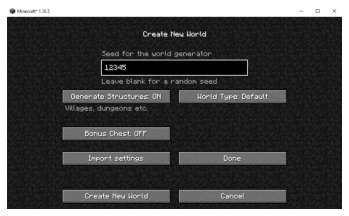
</center>

Now we can do switch out where we choose to embed.

In [18]:
perm = np.linspace(0, cover.size-1, cover.size, dtype='int64')

In [19]:
rng = np.random.default_rng(12345) # <- here we choose the seed

In [20]:
perm = rng.permutation(perm) # <- this shuffles our order around

The rest of the code stays the same.

The differences in pixels between cover and permuted_stego look like this

In [21]:
# iterate elements
stego = cover.copy() #copy the cover

for i, it in enumerate(perm):
    # message exhausted (we are at end of message)
    if len(message_bits) <= i:
        break

    # get index (x- and y-coordinate of pixel we want to change)
    idx = it // cover.shape[1], it % cover.shape[1]

    # make change
    stego[idx] &= ~0 << 1
    stego[idx] |= message_bits[i]

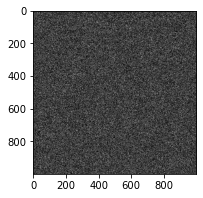

In [22]:
plt.imshow(cover != stego, vmin=0, vmax=1, cmap='gray');

And the LSB planes now look like this. Success!

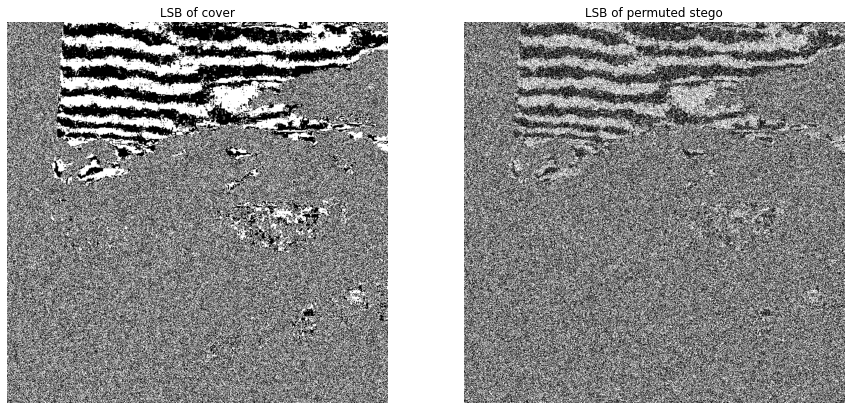

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(cover & 1, cmap = "gray");
ax[1].imshow(stego & 1, cmap = "gray");
for i,t in enumerate(['cover','permuted stego']):
    ax[i].axis('off'); ax[i].set_title(f'LSB of {t}');

## On the receiver's side

In Stego image: Gather LSB bits of pixels along pseudorandom path and convert into characters/letters.

In [24]:
message_bits_extracted = []
for i, it in enumerate(perm): # <- the same pseudorandom path
    
    # get index (x- and y-coordinate)
    idx = it // stego.shape[1], it % stego.shape[1]

    # get message bit
    message_bits_extracted.append(stego[idx] & 1)

    # check end
    if (i + 1) % 8 == 0: # <- stop code '00000000'
        if all([b == 0 for b in message_bits_extracted[-8:]]):
            break

We convert the message bits back to the string message.

In [25]:
# convert to characters
message_bytes_extracted = b''
for i in range(len(message_bits_extracted)//8):
    char_bits = list(message_bits_extracted[i*8:(i+1)*8])

    # decode the byte
    byte = 0
    for i, bit in enumerate(char_bits):
        byte |= bit << i
    message_bytes_extracted += int(byte).to_bytes(1, byteorder='big')

# remove tracing zero
message_extracted = bytes.decode(message_bytes_extracted, 'ascii').split('\0')[0]

In [26]:
message == message_extracted

True

## Take-away messages

- We can hide a message in the LSBs of an image

- Sequential embedding is noticable in homogeneous regions of an image

- Instead: use permuted embedding

- This requires the exchange of a seed/key

## Hands-on: LSBr

- Embed your own message into an image.
- What happens if the keys do not match?


You might find these two functions useful.

In [27]:
import logging
def embed_lsbr(cover, message, key=None): #cover: np.array, message:String
    # encode
    message_bits = []
    for bit in message.encode('ascii') + b'\x00': # <- stop code
        for i in range(8):
            message_bits.append((bit >> i) & 1) # turn characters into 0s and 1s
    message_bits = np.array(message_bits)

    # set order
    perm = np.linspace(0, cover.size-1, cover.size, dtype='int64')
    ## permuted walk-through
    if key is not None:
        rng = np.random.default_rng(key) # <- here we choose the seed
        perm = rng.permutation(perm) # <- this shuffles our order around

    # iterate elements
    stego = cover.copy() #copy the cover

    for i, it in enumerate(perm):
        # message exhausted (we are at end of message)
        if len(message_bits) <= i:
            break

        # get index (x- and y-coordinate of pixel we want to change)
        idx = it // cover.shape[1], it % cover.shape[1]

        # make change
        stego[idx] &= ~0 << 1
        stego[idx] |= message_bits[i]

    return stego


def extract_lsbr(stego, key=None):
    # set order
    perm = np.linspace(0, cover.size-1, cover.size, dtype='int64')
    ## permuted walk-through
    if key is not None:
        rng = np.random.default_rng(key) # <- here we choose the seed
        perm = rng.permutation(perm) # <- this shuffles our order around

    message_bits_extracted = []
    for i, it in enumerate(perm): # <- walk along the same pseudorandom path
        # get index (x- and y-coordinate)
        idx = it // stego.shape[1], it % stego.shape[1]

        # get message bit
        message_bits_extracted.append(stego[idx] & 1)

        # check end
        if (i + 1) % 8 == 0: # <- if we hit our stop code '00000000'
            if all([b == 0 for b in message_bits_extracted[-8:]]):
                break

    # convert to characters
    message_bytes_extracted = b''
    for i in range(len(message_bits_extracted)//8):
        char_bits = list(message_bits_extracted[i*8:(i+1)*8])

        # decode the byte
        byte = 0
        for i, bit in enumerate(char_bits):
            byte |= bit << i
        message_bytes_extracted += int(byte).to_bytes(1, byteorder='big')

    # remove tracing zero
    try:
        message_extracted = bytes.decode(message_bytes_extracted, 'ascii').split('\0')[0]
        return message_extracted
    except UnicodeDecodeError:
        logging.error('can\'t decode message, perhaps wrong key?')
        return None

Load a cover image.

In [28]:
im = np.array(Image.open('nockspitze.png'))

Embed a secret message into the cover image.

In [29]:
stego = embed_lsbr(
    cover,
    "Es ist unmoglich zu summen, wenn man sich die Nase zuhalt!")

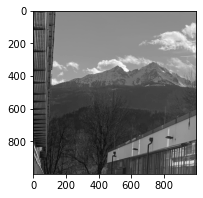

In [30]:
plt.imshow(stego,cmap = "gray");

Extract the secret message from 'stego' using extract_lsbr

In [31]:
extract_lsbr(stego)

'Es ist unmoglich zu summen, wenn man sich die Nase zuhalt!'

What happens if the key does not match?

In [32]:
stego_with_key = embed_lsbr(
    cover,
    "Avocados sind kein Gemuse!",
    key=1997)

In [33]:
extract_lsbr(stego_with_key, key=1997)

'Avocados sind kein Gemuse!'

In [34]:
extract_lsbr(stego_with_key, key=12345)

ERROR:root:can't decode message, perhaps wrong key?
